In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import os


In [4]:
review_raw = pd.read_csv("imdb_labelled.txt", delimiter= '\t', header=None)
review_raw.columns = ['review', 'classif']
second_raw = pd.read_csv("yelp_labelled.txt", delimiter= '\t', header=None)
second_raw.columns = ['review', 'classif']

# Data

There are 748 reviews.
We have 2 types of classification : 0 or 1.

In [5]:
review_raw.classif.unique()

array([0, 1])

In [6]:
review_raw.shape

(748, 2)

In [7]:
review_raw[review_raw.classif==0].sample(10)

,review,classif
110,This movie now joins Revenge of the Boogeyman ...,0
383,"However, here there was no decent acting, acti...",0
125,"If this premise sound stupid, that's because i...",0
104,NOBODY identifies with these characters becaus...,0
389,There is no plot here to keep you going in the...,0
470,"Speaking of the music, it is unbearably predic...",0
505,"The results, well, are a shame.",0
407,"In conclusion, I will not bother with this mov...",0
519,You can find better movies at youtube.,0
95,Worst hour and a half of my life!Oh my gosh!,0


In [8]:
review_raw[review_raw.classif==1].sample(10)

,review,classif
663,I didn't realize how wonderful the short reall...,1
245,The last 15 minutes of movie are also not bad ...,1
563,It's still wild stuff though and is highly rec...,1
698,Both Rickman and Stowe play their roles to the...,1
677,The movie is not completely perfect but 'Titta...,1
690,This is truly an art movie--it actually has a ...,1
425,It's as continuously beautiful to look at as a...,1
216,I would have casted her in that role after rea...,1
207,I rather enjoyed it.,1
585,But the duet between the astronaut and his doc...,1


# Brut force!

Let see at the word that are used in one type fo review and not the other....

In [36]:
import re

In [37]:
words_bad = set()
regex_pat = re.compile(r"\W", flags=re.IGNORECASE)
for i in review_raw[(review_raw.classif==0)].review.str.replace(regex_pat," ",regex=True):
    words_bad = words_bad.union(set(i.lower().split(" ")))
words_good = set()
for i in review_raw[(review_raw.classif==1)].review.str.replace(regex_pat," ",regex=True):
    words_good = words_good.union(set(i.lower().split(" ")))
    
keywords= set(str(k) for k in words_good.union(words_bad) - words_bad.intersection(words_good))

In [38]:
len(keywords)

2298

In [39]:
for key in keywords:
    regex_pat = re.compile(r"\W"+str(key) + '\W', flags=re.IGNORECASE)
    review_raw[str(key)] = review_raw.review.str.contains(
        regex_pat
    )
    second_raw[str(key)] = second_raw.review.str.contains(
        regex_pat
    )

In [352]:
review_raw["question"] = review_raw.review.str.contains("\?")
review_raw["love"] = review_raw.review.str.contains("love*")



In [353]:
review_raw["length"] = review_raw.review.str.len()

In [354]:
review_raw["length_class"]=pd.cut(review_raw.length,[0,50,150,200,max(review_raw.length)])

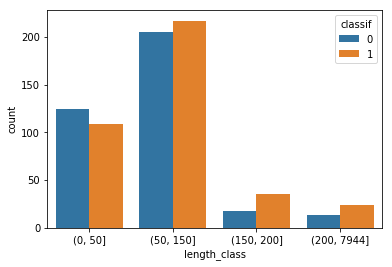

In [355]:
sns.countplot(data=review_raw,x="length_class",hue="classif")


In [ ]:
sns.heatmap(review_raw.corr())

In [28]:
data = review_raw[list(keywords)]
target = review_raw.classif

In [29]:
# Our data is binary / boolean, so we're importing the Bernoulli classifier.
from sklearn.naive_bayes import BernoulliNB

# Instantiate our model and store it in a new variable.
bnb = BernoulliNB()

# Fit our model to the data.
bnb.fit(data, target)

# Classify, storing the result in a new variable.
y_pred = bnb.predict(data)

# Display our results.
print("Number of mislabeled points out of a total {} points : {}".format(
    data.shape[0],
    (target != y_pred).sum()
))
review_raw["result"] = True
review_raw.loc[(target != y_pred),"result"] = False

Number of mislabeled points out of a total 748 points : 62


In [30]:
review_raw.shape

(748, 2301)

In [31]:
pd.crosstab(review_raw.classif,review_raw.result)

result,False,True
classif,,
0,62,300
1,0,386


In [32]:
data_2 = second_raw[list(keywords)]
target_2 = second_raw.classif

In [33]:
y_pred_2 = bnb.predict(data_2)

# Display our results.
print("Number of mislabeled points out of a total {} points : {}".format(
    data_2.shape[0],
    (target_2 != y_pred_2).sum()
))
second_raw["result"] = True
second_raw.loc[(target_2 != y_pred_2),"result"] = False
pd.crosstab(second_raw.classif,second_raw.result)

Number of mislabeled points out of a total 1000 points : 406


result,False,True
classif,,
0,295,205
1,111,389


We are basically over-fitting the Imdb reviews, but an only get 60% of the labelling correct for Yelp: this is not very good...

# A more subtle way ?

Let see if we can do better by selecting keywords that will make more sense.. and some feather engineering.

In [47]:
review_raw = pd.read_csv("imdb_labelled.txt", delimiter= '\t', header=None)
review_raw.columns = ['review', 'classif']
second_raw = pd.read_csv("yelp_labelled.txt", delimiter= '\t', header=None)
second_raw.columns = ['review', 'classif']

In [48]:
keywords = ['awful', 'bad', 'worst', 'barely','predictable','boring', 'irritating', 'good', 'wonderful',"trash","pointless","waste","but"
           ,'disappointing',"cheap","poor",'DO NOT RENT','aimless','nonetheless','horrendous',"avoid","terrible","shameful","best"]


In [64]:
for key in keywords:
    regex_pat = re.compile(r"\W"+str(key) + '\W', flags=re.IGNORECASE)
    review_raw[str(key)] = review_raw.review.str.contains(
        regex_pat
    )
    second_raw[str(key)] = second_raw.review.str.contains(
        regex_pat
    )

By looking at the reviews, it seems that negative reviews often finish with a question mark, let's see if this is indeed true:

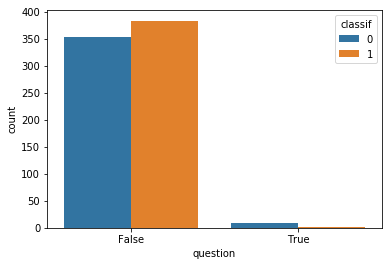

In [93]:
review_raw["question"] = review_raw.review.str.contains("\?")
review_raw["love"] = review_raw.review.str.contains("love*")

second_raw["question"] = second_raw.review.str.contains("\?")
second_raw["love"] = second_raw.review.str.contains("love*")

sns.countplot(data=review_raw,x="question",hue="classif")



Indeed it seems that review with a question mark are more likely to be negative, and positive when they do not have one.

# Review length : can it help?

Assumtion here is that when you like a film, you are more likely to give a longer review...

We can test this hypothesis.

In [95]:
review_raw["length"] = review_raw.review.str.len()
second_raw["length"] = second_raw.review.str.len()


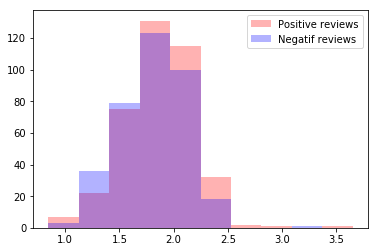

In [112]:
_,bins,_  = plt.hist(np.log10(review_raw[review_raw.classif==1].length),bins=10,color="red",label="Positive reviews",alpha=0.3)
plt.hist(np.log10(review_raw[review_raw.classif==0].length),bins=bins,color="blue",label="Negatif reviews",alpha=0.3)
plt.legend()

Here again the difference seems to be subtle, but there is still one, so we can see if it helps with the classification by binning the length variable.

In [97]:
review_raw["length_class"]= review_raw.length>60
second_raw["length_class"]= second_raw.length>60

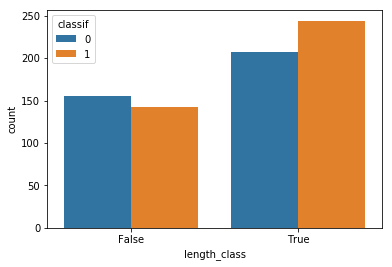

In [98]:
sns.countplot(data=review_raw,x="length_class",hue="classif")


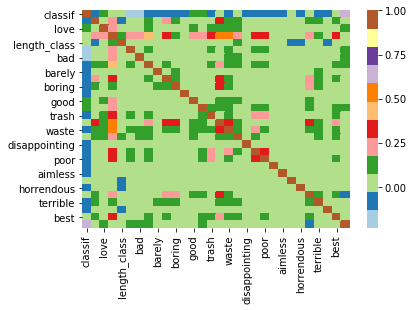

In [99]:
sns.heatmap(review_raw.corr(),cmap=plt.get_cmap("Paired"))

In [100]:
data = review_raw[list(keywords)+["question","length_class","love"]]
target = review_raw.classif

In [101]:
# Our data is binary / boolean, so we're importing the Bernoulli classifier.
from sklearn.naive_bayes import BernoulliNB

# Instantiate our model and store it in a new variable.
bnb = BernoulliNB()

# Fit our model to the data.
bnb.fit(data, target)

# Classify, storing the result in a new variable.
y_pred = bnb.predict(data)

# Display our results.
print("Number of mislabeled points out of a total {} points : {}".format(
    data.shape[0],
    (target != y_pred).sum()
))
review_raw["result"] = True
review_raw.loc[(target != y_pred),"result"] = False

Number of mislabeled points out of a total 748 points : 251


In [102]:
review_raw.shape

(748, 31)

In [103]:
pd.crosstab(review_raw.classif,review_raw.result)

result,False,True
classif,,
0,242,120
1,9,377


In [106]:
data_2 = second_raw[list(keywords)+["question","length_class","love"]]
target_2 = second_raw.classif

In [107]:
y_pred_2 = bnb.predict(data_2)

# Display our results.
print("Number of mislabeled points out of a total {} points : {}".format(
    data_2.shape[0],
    (target_2 != y_pred_2).sum()
))
second_raw["result"] = True
second_raw.loc[(target_2 != y_pred_2),"result"] = False
pd.crosstab(second_raw.classif,second_raw.result)

Number of mislabeled points out of a total 1000 points : 439


result,False,True
classif,,
0,439,61
1,0,500


It the second attemps, we get a much lower classification rate on Imbd, but almost the same rate for yelp.

Looking at the IMDB review, it seems that a lot of the reviews are "sarcasstic", meaning that they are more difficult to find using a simple Naive Bayes model.
